# Driver Lifetime Value
source: https://platform.stratascratch.com/data-projects/driver-lifetime-value

### Assumptions
(1) The data is from 2016-03 to 2026-06. It is typically not enough duration to observe the life time of the driver. However, given limited data, I assume the life time of all drivers are observed within this period

(2) Without knowing how much revenue is paid back to the driver, I assumn the life time value of the driver is the total revenue generated by the driver

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from datetime import time
from sklearn import set_config


In [27]:
set_config(transform_output="pandas")

In [4]:
driver = pd.read_csv("./datasets/driver_ids.csv")
ride = pd.read_csv("./datasets/ride_ids.csv")
ridets = pd.read_csv("./datasets/ride_timestamps.csv")

print(driver.info())
print(ride.info())
print(ridets.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   driver_id            937 non-null    object
 1   driver_onboard_date  937 non-null    object
dtypes: object(2)
memory usage: 14.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   driver_id        193502 non-null  object
 1   ride_id          193502 non-null  object
 2   ride_distance    193502 non-null  int64 
 3   ride_duration    193502 non-null  int64 
 4   ride_prime_time  193502 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     -

### (1) Feature engineering

In [5]:
# Pivot ride timestamps
ridets["timestamp"] = pd.to_datetime(ridets["timestamp"])
ridets_pivot = (
    ridets.pivot(index="ride_id", columns="event", values="timestamp")
    .reset_index()
    .assign(
        request_to_accept=lambda x: (x.accepted_at - x.requested_at).dt.total_seconds(),
        pickup_to_dropoff=lambda x: (x.dropped_off_at - x.picked_up_at)
        / pd.Timedelta(minutes=1),
    )
)


In [6]:
# Merge driver, ride and ride_ts
trips = ride.merge(ridets_pivot, on="ride_id", how="inner", validate="1:1").merge(
    driver, on="driver_id", how="inner", validate="m:1"
)
print(f"{driver.shape=} {ride.shape=} {ridets_pivot.shape=} {trips.shape=}")

driver.shape=(937, 2) ride.shape=(193502, 5) ridets_pivot.shape=(194081, 8) trips.shape=(184209, 13)


In [7]:
# Calculate fares
trips = trips.assign(
    bare_fare=lambda x: (
        2 + 0.22 * x.ride_duration / 60 + 1.15 * x.ride_distance / 1609.34
    )
    * (100 + x.ride_prime_time)
    / 100
    + 1.75,
    final_fare=lambda x: np.minimum(400, np.maximum(5, x.bare_fare)),
)


In [8]:
# Active days
# Total trips
# Total distance
# Total duration
# Total prime time
# Total fare
# Tenure
# pct_active
# Average trips per day
# Average distance per day
# Average duration per day
# Average distance per trip
# Average prime time per day
# Average speed
# Dominant working hours: Morning, Afternoon, Evening, Night

driveragg = (
    trips.assign(
        active_date=lambda x: x.accepted_at.dt.date,
        driver_onboard_date=lambda x: pd.to_datetime(x.driver_onboard_date),
        tenure=lambda x: (pd.to_datetime("2016-06-30") - x.driver_onboard_date).dt.days,
        prime_trip=lambda x: np.where(x.ride_prime_time > 0, 1, 0),
        accepted_ts=lambda x: x.accepted_at.dt.time,
        trip_time=lambda x: x.accepted_ts.case_when(
            [
                (x.accepted_ts.between(time(6, 00), time(11, 59)), "Morning"),
                (x.accepted_ts.between(time(12, 00), time(17, 59)), "Afternoon"),
                (x.accepted_ts.between(time(18, 00), time(23, 59)), "Evening"),
                (x.accepted_ts.between(time(0, 00), time(5, 59)), "Midnight"),
            ]
        ),
    )
    .groupby(["driver_id", "tenure"], as_index=False)
    .agg(
        driver_onboard_date=("driver_onboard_date", "min"),
        active_days=("active_date", "nunique"),
        last_active_day=("accepted_at", "max"),
        total_trips=("ride_id", "nunique"),
        total_distance=("ride_distance", "sum"),
        total_duration=("ride_duration", "sum"),
        total_fare=("final_fare", "sum"),
        total_prime=("ride_prime_time", "sum"),
        total_prime_trip=("prime_trip", "sum"),
        time_mode=("trip_time", lambda x: x.mode()[0]),
    )
    .assign(
        lifetime=lambda x: (x.last_active_day - x.driver_onboard_date).dt.days,
        pct_active=lambda x: x.active_days / x.tenure,
        pct_prime=lambda x: x.total_prime_trip / x.total_trips,
        trips_pday=lambda x: x.total_trips / x.active_days,
        distance_pday=lambda x: x.total_distance / x.active_days,
        duration_pday=lambda x: x.total_duration / x.active_days,
        distance_ptrip=lambda x: x.total_distance / x.total_trips,
        prime_pday=lambda x: x.total_prime / x.active_days,
        fare_ptenure=lambda x: x.total_fare / x.tenure,
        avg_speed=lambda x: x.total_distance / x.total_duration,
    )
)

In [9]:
driveragg.value_counts("time_mode")

time_mode
Evening      426
Afternoon    211
Morning      173
Midnight      27
Name: count, dtype: int64

In [10]:
driveragg.columns

Index(['driver_id', 'tenure', 'driver_onboard_date', 'active_days',
       'last_active_day', 'total_trips', 'total_distance', 'total_duration',
       'total_fare', 'total_prime', 'total_prime_trip', 'time_mode',
       'lifetime', 'pct_active', 'pct_prime', 'trips_pday', 'distance_pday',
       'duration_pday', 'distance_ptrip', 'prime_pday', 'fare_ptenure',
       'avg_speed'],
      dtype='object')

### (2) Driver lifetime value

In [11]:
driveragg.total_fare.mean()

2979.8596114979996

### (3) Average life time

In [12]:
print(f"{driveragg.lifetime.mean()} days")

55.075268817204304 days


### (4) CATGBM to predict total lifetime value

In [13]:
target = "total_fare"
num_predictors = [
    "pct_active",
    "pct_prime",
    "trips_pday",
    "distance_ptrip",
    "avg_speed",
]
cat_predictors = ["time_mode"]
predictors = num_predictors + cat_predictors

,pct_active,pct_prime,trips_pday,distance_ptrip,avg_speed
pct_active,1.000000,0.279598,0.470902,-0.041977,-0.095070
pct_prime,0.279598,1.000000,0.275588,-0.361159,-0.427968
trips_pday,0.470902,0.275588,1.000000,-0.280506,-0.310613
distance_ptrip,-0.041977,-0.361159,-0.280506,1.000000,0.868554
avg_speed,-0.095070,-0.427968,-0.310613,0.868554,1.000000


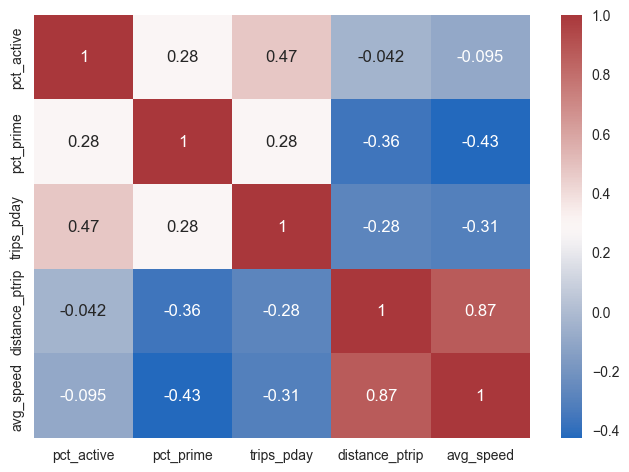

In [14]:
preddf = driveragg[num_predictors]
corrmap = preddf.corr()
sns.heatmap(corrmap, cmap="vlag", annot=True)
corrmap

In [15]:
X = driveragg[predictors]
y = driveragg[[target]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

In [16]:
mdl = CatBoostRegressor(
    cat_features=cat_predictors,
    n_estimators=20000,
    learning_rate=0.01,
    early_stopping_rounds=100,
    random_state=777,
)

model1 = mdl.fit(X=X_train, y=y_train, eval_set=(X_test, y_test), verbose=100)

0:	learn: 2418.7210031	test: 2356.1525810	best: 2356.1525810 (0)	total: 196ms	remaining: 1h 5m 26s
100:	learn: 1303.0033744	test: 1304.8471038	best: 1304.8471038 (100)	total: 2.58s	remaining: 8m 27s
200:	learn: 900.3595385	test: 941.7780951	best: 941.7780951 (200)	total: 4.98s	remaining: 8m 10s
300:	learn: 746.8252223	test: 814.7295617	best: 814.7295617 (300)	total: 7.44s	remaining: 8m 6s
400:	learn: 675.5061742	test: 770.9600342	best: 770.9600342 (400)	total: 9.94s	remaining: 8m 5s
500:	learn: 635.7252375	test: 756.3920192	best: 756.1297242 (499)	total: 12.4s	remaining: 8m 3s
600:	learn: 607.7212967	test: 747.5663769	best: 747.3840732 (596)	total: 14.9s	remaining: 8m
700:	learn: 585.7637129	test: 744.2044972	best: 744.1381078 (699)	total: 17.3s	remaining: 7m 57s
800:	learn: 565.3357656	test: 744.1279777	best: 743.0003894 (759)	total: 19.8s	remaining: 7m 53s
900:	learn: 548.1699499	test: 742.9868756	best: 742.5771437 (852)	total: 22.3s	remaining: 7m 52s
Stopped by overfitting detector 

In [17]:
fi_df = pd.DataFrame({"features": predictors, "score": model1.get_feature_importance()})
fi_df.sort_values("score", ascending=False)

,features,score
0,pct_active,64.256646
2,trips_pday,25.925606
3,distance_ptrip,3.727918
1,pct_prime,2.319084
5,time_mode,2.064699
4,avg_speed,1.706046


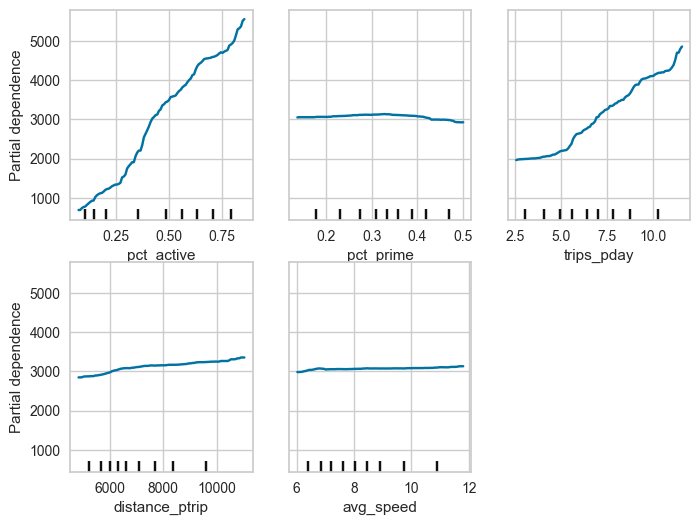

In [18]:
pd = PartialDependenceDisplay.from_estimator(model1, X_train, features=range(5))
pd.figure_.set_size_inches(8, 6)

<Axes: xlabel='time_mode', ylabel='total_fare'>

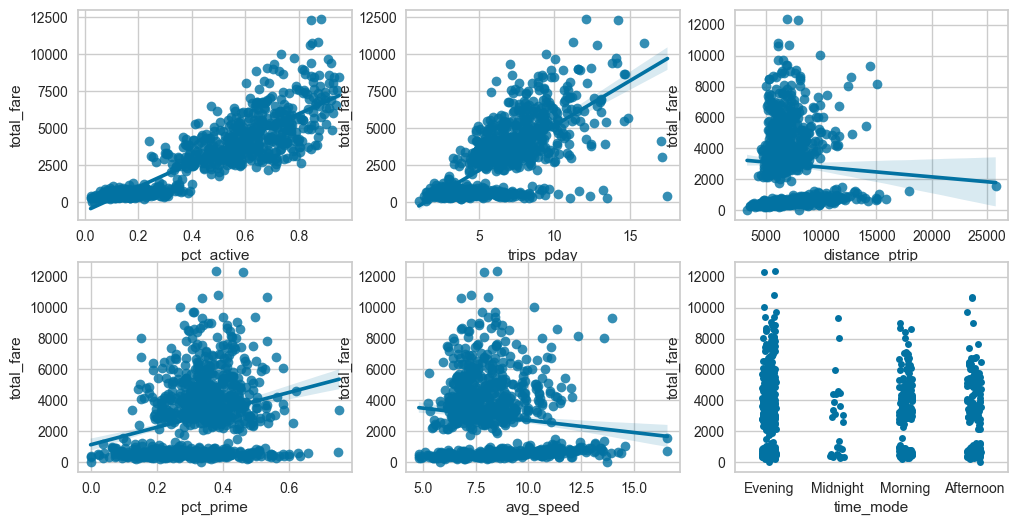

In [19]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=3, nrows=2)
sns.regplot(data=driveragg, x="pct_active", y="total_fare", ax=ax[0, 0])
sns.regplot(driveragg, x="trips_pday", y="total_fare", ax=ax[0, 1])
sns.regplot(driveragg, x="distance_ptrip", y="total_fare", ax=ax[0, 2])
sns.regplot(driveragg, x="pct_prime", y="total_fare", ax=ax[1, 0])
sns.regplot(driveragg, x="avg_speed", y="total_fare", ax=ax[1, 1])
sns.stripplot(driveragg, x="time_mode", y="total_fare", ax=ax[1, 2])


### (4) Driver clustering analysis

In [42]:
driveragg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   driver_id            837 non-null    object        
 1   tenure               837 non-null    int64         
 2   driver_onboard_date  837 non-null    datetime64[ns]
 3   active_days          837 non-null    int64         
 4   last_active_day      837 non-null    datetime64[ns]
 5   total_trips          837 non-null    int64         
 6   total_distance       837 non-null    int64         
 7   total_duration       837 non-null    int64         
 8   total_fare           837 non-null    float64       
 9   total_prime          837 non-null    int64         
 10  total_prime_trip     837 non-null    int32         
 11  time_mode            837 non-null    object        
 12  lifetime             837 non-null    int64         
 13  pct_active           837 non-null  

In [46]:
num_vars = driveragg.select_dtypes(exclude=["object", "datetime64[ns]"]).columns
num_vars

Index(['tenure', 'active_days', 'total_trips', 'total_distance',
       'total_duration', 'total_fare', 'total_prime', 'total_prime_trip',
       'lifetime', 'pct_active', 'pct_prime', 'trips_pday', 'distance_pday',
       'duration_pday', 'distance_ptrip', 'prime_pday', 'fare_ptenure',
       'avg_speed'],
      dtype='object')

In [47]:
transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False), ["time_mode"]),
        ("num", "passthrough", num_vars),
    ],
    remainder="drop",
)
driver_t = transformer.fit_transform(driveragg)
driver_t

,cat__time_mode_Afternoon,cat__time_mode_Evening,cat__time_mode_Midnight,cat__time_mode_Morning,num__tenure,num__active_days,num__total_trips,num__total_distance,num__total_duration,num__total_fare,...,num__lifetime,num__pct_active,num__pct_prime,num__trips_pday,num__distance_pday,num__duration_pday,num__distance_ptrip,num__prime_pday,num__fare_ptenure,num__avg_speed
0,0.0,1.0,0.0,0.0,93,56,277,1740287,221238,3560.926071,...,86,0.602151,0.397112,4.946429,31076.553571,3950.678571,6282.624549,95.982143,38.289528,7.866131
1,0.0,1.0,0.0,0.0,93,12,31,117531,20497,321.494948,...,85,0.129032,0.387097,2.583333,9794.250000,1708.083333,3791.322581,52.083333,3.456935,5.734059
2,0.0,1.0,0.0,0.0,86,12,34,269653,29205,482.428390,...,68,0.139535,0.470588,2.833333,22471.083333,2433.750000,7930.970588,56.250000,5.609632,9.233111
3,0.0,0.0,1.0,0.0,68,40,191,1471239,174521,2610.871561,...,64,0.588235,0.251309,4.775000,36780.975000,4363.025000,7702.821990,51.250000,38.395170,8.430155
4,0.0,0.0,0.0,1.0,62,40,375,3123644,357443,5381.097539,...,56,0.645161,0.264000,9.375000,78091.100000,8936.075000,8329.717333,117.500000,86.791896,8.738859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1.0,0.0,0.0,0.0,65,36,242,2002400,246308,3538.377658,...,61,0.553846,0.289256,6.722222,55622.222222,6841.888889,8274.380165,86.111111,54.436579,8.129659
833,0.0,0.0,0.0,1.0,94,61,485,2834765,442492,6287.368597,...,81,0.648936,0.375258,7.950820,46471.557377,7253.967213,5844.876289,141.393443,66.886900,6.406364
834,1.0,0.0,0.0,0.0,83,16,35,174394,27693,380.661435,...,34,0.192771,0.114286,2.187500,10899.625000,1730.812500,4982.685714,10.937500,4.586282,6.297404
835,0.0,1.0,0.0,0.0,55,47,406,2924913,353974,6052.149594,...,51,0.854545,0.529557,8.638298,62232.191489,7531.361702,7204.219212,256.382979,110.039084,8.263073


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=15, random_state=777),
                 k=(2, 16))

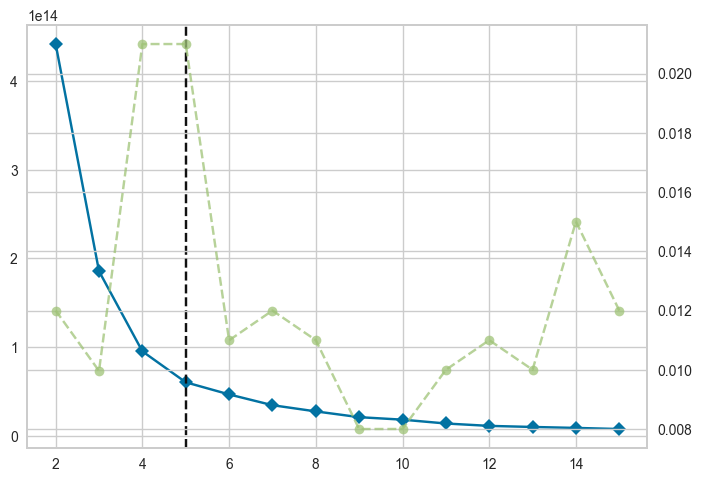

In [59]:
# Use the KElbowVisualizer to determine the optimal number of clusters
KMeans_model = KMeans(random_state=777)
visualizer = KElbowVisualizer(KMeans_model, k=(2, 16))
visualizer.fit(driver_t)

In [68]:
# Select K = 5
KMeans_model = KMeans(n_clusters=5, random_state=777)
driver_cluster = KMeans_model.fit_predict(driver_t)
driver_cluster = pd.DataFrame({"cluster": driver_cluster})
driver2 = pd.concat([driveragg, driver_cluster], axis=1)


<Axes: xlabel='cluster', ylabel='time_mode'>

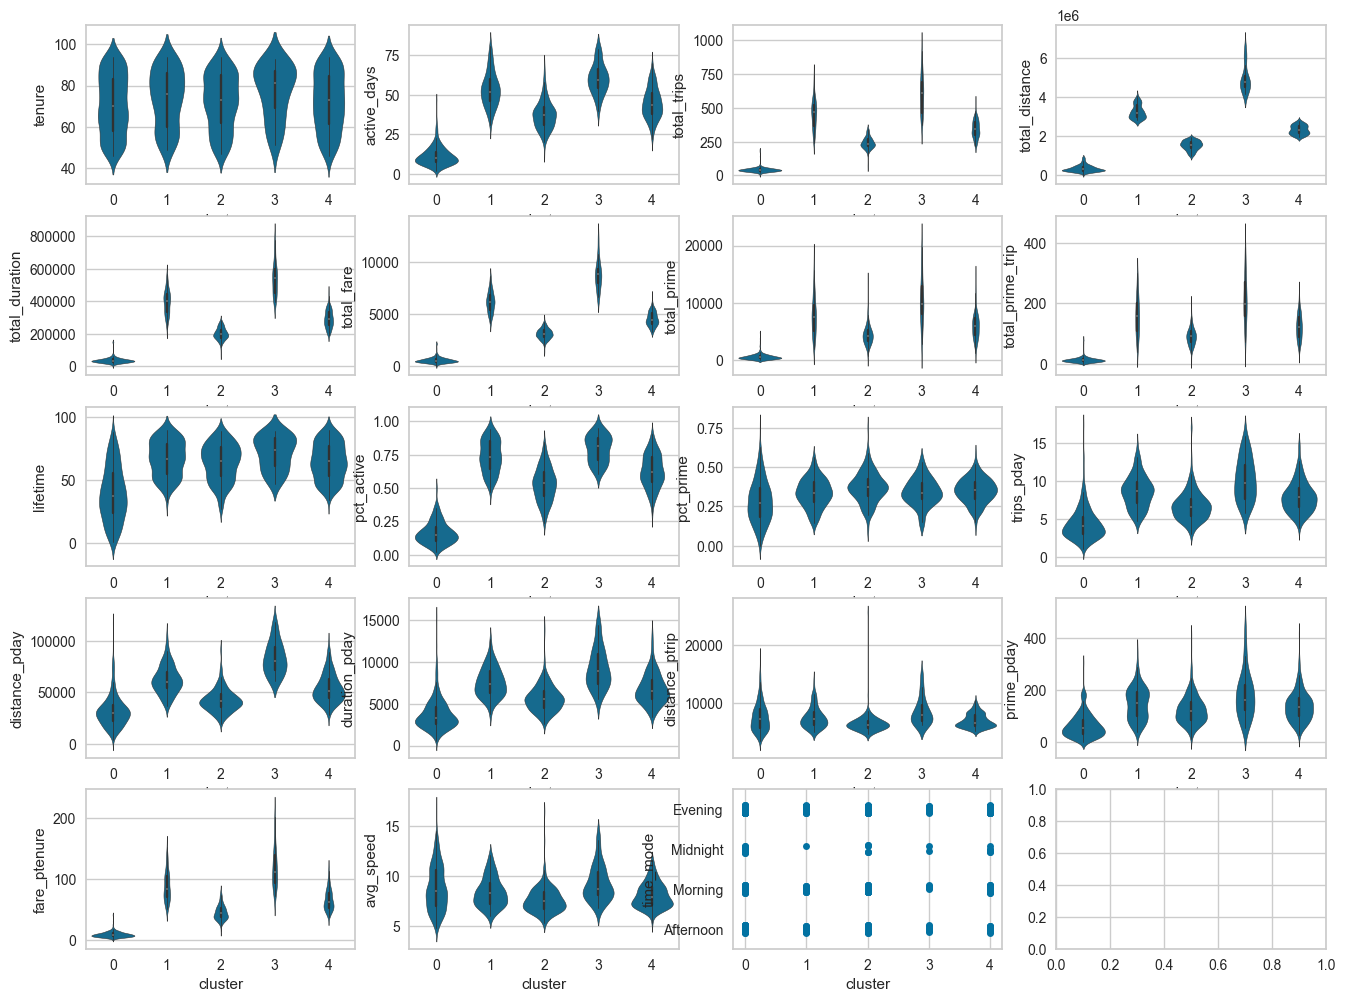

In [83]:
n = len(num_vars)
ncol = 4
nrow = 5
fig, ax = plt.subplots(figsize=(16, 12), ncols=ncol, nrows=nrow)


def plt_violin(y, i, ncol):
    row = i // ncol
    col = i % ncol
    sns.violinplot(driver2, x="cluster", y=y, ax=ax[row, col])


for i, y in enumerate(num_vars):
    plt_violin(y, i, ncol)

sns.stripplot(driver2, x="cluster", y="time_mode", ax=ax[4, 2])